# Feature Selection – Embedded Methods

Till now, I explored [**Filter**](https://github.com/Aman-sys-ui/Machine_Learning/blob/main/feature_selection/Feature_Selection_Via_Filter_Method.ipynb) and [**Wrapper**](https://github.com/Aman-sys-ui/Machine_Learning/blob/main/feature_selection/feature_selection_via_wrapper_method.ipynb) methods for feature selection.  
They worked well, but:

- Filter methods are too simple – they ignore interactions between features.
- Wrapper methods are too slow – they train multiple models for different feature subsets.

**Embedded methods solve both problems** by doing feature selection **as part of model training**.  
This makes them **efficient** and allows them to consider **feature interactions**.

In this notebook, I want to go **deep** and really understand:

- What each embedded method does under the hood
- When to use which method
- How to implement them step by step with code
- How performance changes when I actually drop features


## Types of Embedded Methods

**Lasso Regression (L1)** → Performs automatic feature selection by shrinking some coefficients to zero ·  
**Ridge Regression (L2)** → Shrinks coefficients to reduce multicollinearity but keeps all features ·  
**Elastic Net (L1 + L2)** → Combines Lasso and Ridge to handle correlated features while performing selection ·  
**Tree-based Feature Importance (Random Forest / Decision Trees)** → Uses model-inherent feature importance to select relevant features without assuming linearity


## Baseline Model – Breast Cancer Dataset

Before diving into embedded methods, I want to set up a **baseline model** using all features.  
This will help me **compare performance later** when we drop features using Lasso, Ridge, Elastic Net, or Tree-based methods.

We are using **Breast Cancer dataset** from `sklearn` because it has a good number of features and is widely used for classification practice.


In [39]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split ,cross_val_score ,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,f1_score , classification_report

In [40]:
# Load dataset
df = load_breast_cancer()
X = pd.DataFrame(df.data , columns = df.feature_names)
y = pd.Series(df.target)

In [41]:
# Quick exploration
print("Shape of dataset:", X.shape)
X.head()

Shape of dataset: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [42]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
# Feature scaling (important for regularization-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
# Baseline Logistic Regression (all features)
baseline_model = LogisticRegression(max_iter=10000, random_state=42)

In [45]:
# Stratified 5-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [46]:
# Accuracy
acc_scores = cross_val_score(baseline_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')

In [47]:
# F1-score (macro average)
f1_scores = cross_val_score(baseline_model, X_train_scaled, y_train, cv=skf, scoring='f1_macro')

print(f"Baseline CV Accuracy (5-fold): {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"Baseline CV F1-score (5-fold): {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

Baseline CV Accuracy (5-fold): 0.9780 ± 0.0098
Baseline CV F1-score (5-fold): 0.9764 ± 0.0106


### Observations from Baseline Model

- Accuracy and F1-score give us a **reference point** before any feature selection.  
- We are using all 30 features of the dataset.  
- Now, we can start applying **embedded methods** to see:
  - Which features are important
  - Whether dropping irrelevant features affects performance


## 1️. Lasso Regression (L1 Regularization)

**What is Lasso?**  
Lasso (Least Absolute Shrinkage and Selection Operator) is a linear regression model that uses **L1 regularization**.  
It **automatically performs feature selection** by shrinking some coefficients exactly to zero while keeping others.  
This is useful when I want a **sparse model**, i.e., a model using only the most important features.

---

**Mathematical Formulation**

The cost function of Lasso is:

$$
J(\beta) = \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} |\beta_j|
$$

Where:  
- $y_i$ = true target  
- $\hat{y}_i$ = predicted target  
- $n$ = number of samples  
- $p$ = number of features  
- $\beta_j$ = coefficient for feature $j$  
- $\lambda$ = regularization parameter controlling **shrinkage**

**Explanation of the Formula:**

1. First term: **Mean Squared Error (MSE)** → measures model fit  
2. Second term: **L1 penalty** → adds absolute value of coefficients  
   - Large $\lambda$ → more coefficients shrink to 0 → more feature selection  
   - Small $\lambda$ → behaves like regular linear regression  

**Intuition:**  
- Lasso pushes **irrelevant features** to zero because the L1 penalty grows linearly with coefficient size.  
- This is different from Ridge (L2), which **shrinks but rarely zeroes** coefficients.  
- Visual analogy: Lasso “clips” unimportant coefficients while leaving important ones relatively untouched.


In [48]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

In [49]:
# Fit Lasso with cross-validation to select best alpha
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [50]:
# Coefficients
lasso_coefs = pd.Series(lasso.coef_, index=X.columns)

In [51]:
# Number of features selected (non-zero coefficients)
num_selected = sum(lasso_coefs != 0)
print(f"Optimal alpha (λ) chosen by CV: {lasso.alpha_:.4f}")
print(f"Number of features selected by Lasso: {num_selected}")
print("\nSelected Features:\n", lasso_coefs[lasso_coefs != 0])

Optimal alpha (λ) chosen by CV: 0.0009
Number of features selected by Lasso: 23

Selected Features:
 mean texture              -0.028249
mean smoothness           -0.017779
mean compactness           0.169038
mean concavity            -0.066122
mean concave points       -0.057553
mean symmetry             -0.010035
radius error              -0.127322
texture error             -0.001874
perimeter error            0.032705
area error                 0.043767
smoothness error          -0.051740
concavity error            0.114589
concave points error      -0.056599
symmetry error             0.003312
fractal dimension error    0.008608
worst radius              -0.522829
worst texture             -0.043417
worst area                 0.348743
worst smoothness          -0.004369
worst concavity           -0.116376
worst concave points      -0.075038
worst symmetry            -0.043301
worst fractal dimension   -0.057375
dtype: float64


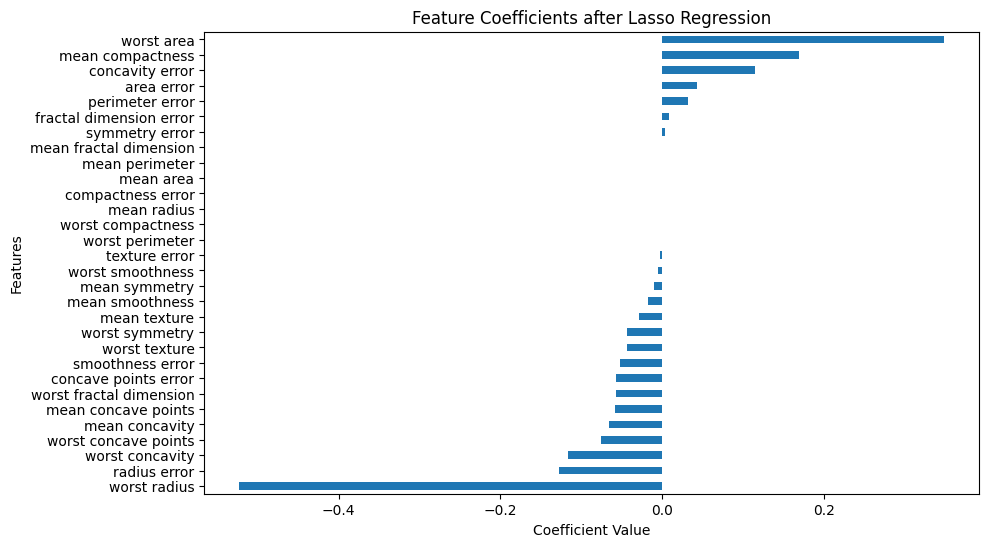

In [52]:
# Plot coefficient magnitudes
plt.figure(figsize=(10,6))
lasso_coefs.sort_values().plot(kind='barh')
plt.title("Feature Coefficients after Lasso Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()

**Retrain Model on Selected Features and Compare with Baseline**

In [53]:
# Used the same CV strategy as baseline
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Keep only features selected by Lasso
selected_features = lasso_coefs[lasso_coefs != 0].index
X_selected = X[selected_features]

# Logistic Regression model
lasso_model_cv = LogisticRegression(max_iter=10000, random_state=42)

# Evaluate with cross-validation (Accuracy)
acc_scores = cross_val_score(lasso_model_cv, X_selected, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(lasso_model_cv, X_selected, y, cv=cv, scoring='f1')

print(f"Lasso Selected Features Accuracy (CV mean): {acc_scores.mean():.4f}")
print(f"Lasso Selected Features F1-score (CV mean): {f1_scores.mean():.4f}")

Lasso Selected Features Accuracy (CV mean): 0.9490
Lasso Selected Features F1-score (CV mean): 0.9599


### Inference from Lasso Feature Selection

- Using **Lasso regression**, we reduced the number of features by keeping only the most important ones.  
- **Baseline model (all 30 features)**:  
  - CV Accuracy: 0.9780 ± 0.0098  
  - CV F1-score: 0.9764 ± 0.0106  

- **Lasso-selected features (23 features)**:  
  - CV Accuracy: 0.9490  
  - CV F1-score: 0.9599  

**Key Takeaways:**

1. Lasso removed several irrelevant or less important features, simplifying the model.  
2. There is a **small drop in accuracy and F1-score**, but it is still very high → shows that the removed features were mostly redundant.  
3. This demonstrates the **power of embedded methods**:
   - Automatic feature selection
   - Reduced dimensionality
   - Easier interpretability  
4. For datasets with many irrelevant features, Lasso is a **great first step** to reduce noise before training more complex models.  

Overall, we achieved a **sparser model** with almost comparable performance, which is exactly what Lasso is designed to do.  



### Pros of Lasso

- Automatically selects **relevant features** → reduces dimensionality.  
- Produces a **sparse and interpretable model**.  
- Helps reduce **overfitting** by removing noisy features.  
- Cross-validation helps choose the optimal **λ** for best performance.

### Cons of Lasso

- Can be unstable if **features are highly correlated** → may randomly keep one and drop the others.  
- Might **drop too many features** if λ is too high → risk of underfitting.  
- Only works with models that support **L1 regularization** (mostly linear models).  


## 2️ .Ridge Regression (L2 Regularization)

**What is Ridge?**  
Ridge regression is a linear model that uses **L2 regularization**.  
Unlike Lasso, Ridge **does not zero out coefficients**, but it **shrinks them towards zero** to reduce multicollinearity and prevent overfitting.  

---

**Mathematical Formulation**

The cost function of Ridge is:

$$
J(\beta) = \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2
$$

Where:  
- $y_i$ = true target  
- $\hat{y}_i$ = predicted target  
- $n$ = number of samples  
- $p$ = number of features  
- $\beta_j$ = coefficient for feature $j$  
- $\lambda$ = regularization parameter controlling shrinkage  

**Explanation:**
1. First term: **MSE** → measures model fit.  
2. Second term: **L2 penalty** → sum of squared coefficients.  
   - Large $\lambda$ → stronger shrinkage, coefficients become smaller  
   - Small $\lambda$ → behaves like ordinary linear regression  

**Intuition:**  
- Ridge reduces the impact of less important features **without removing them completely**.  
- Works well when features are **highly correlated** because it distributes weight among them.  

**When to Use:**  
- When multicollinearity exists among features  
- When we want **all features** to contribute but reduce overfitting  
- When a **stable and smooth model** is preferred over sparsity


In [54]:
from sklearn.linear_model import RidgeCV

# Ridge regression with cross-validation to select best alpha
ridge_alphas = np.logspace(-3, 3, 50)
ridge = RidgeCV(alphas=ridge_alphas, cv=cv, scoring='neg_mean_squared_error')
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
       2.81176870e-01, 3.72759372e-0...
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03]),
        cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
        scoring='neg_mean_squared_error')

In [55]:
# Coefficients
ridge_coefs = pd.Series(ridge.coef_, index=X.columns)

# display coefficient shrinkage (no feature is exactly zero)
print(f"Optimal alpha (λ) chosen by CV: {ridge.alpha_:.4f}")
print("\nTop 10 features by magnitude:\n", ridge_coefs.abs().sort_values(ascending=False).head(10))

Optimal alpha (λ) chosen by CV: 3.5565

Top 10 features by magnitude:
 worst radius            0.198867
radius error            0.186122
mean compactness        0.163648
worst area              0.160636
concavity error         0.107929
worst concavity         0.105083
mean area               0.102039
mean radius             0.101699
worst concave points    0.084242
mean perimeter          0.080179
dtype: float64


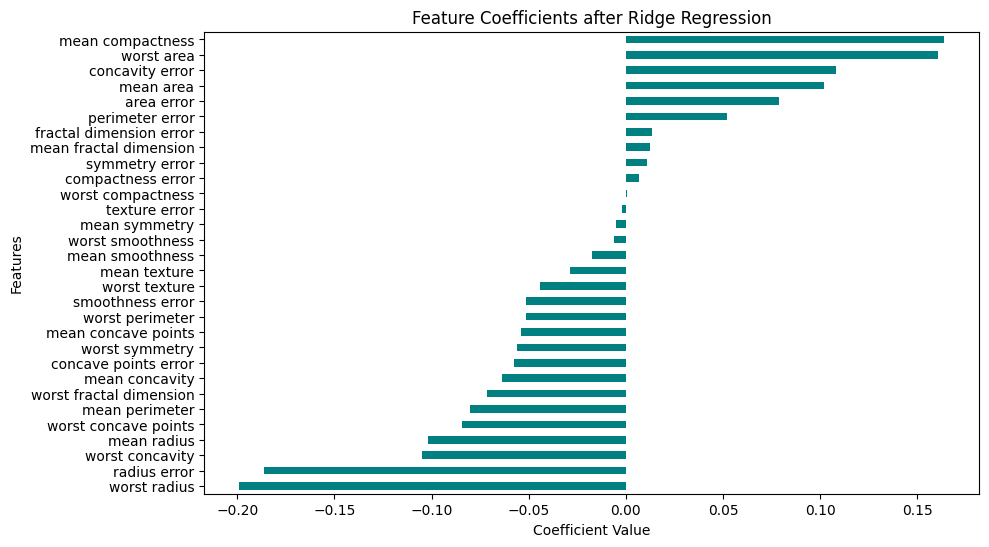

In [56]:
# Plot Ridge coefficients
plt.figure(figsize=(10,6))
ridge_coefs.sort_values().plot(kind='barh', color='teal')
plt.title("Feature Coefficients after Ridge Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()

**Evaluation with Same CV as Baseline**

In [57]:
# Logistic Regression on all features is fine, but Ridge gives us coefficients to observe shrinkage
# Evaluate using cross-validation
ridge_model_cv = LogisticRegression(max_iter=10000, random_state=42)

# Accuracy & F1-score with 5-fold CV
acc_ridge = cross_val_score(ridge_model_cv, X_train_scaled, y_train, cv=cv, scoring='accuracy')
f1_ridge = cross_val_score(ridge_model_cv, X_train_scaled, y_train, cv=cv, scoring='f1')

print(f"Ridge Coefficients Evaluation Accuracy (CV mean): {acc_ridge.mean():.4f} ± {acc_ridge.std():.4f}")
print(f"Ridge Coefficients Evaluation F1-score (CV mean): {f1_ridge.mean():.4f} ± {f1_ridge.std():.4f}")

Ridge Coefficients Evaluation Accuracy (CV mean): 0.9780 ± 0.0098
Ridge Coefficients Evaluation F1-score (CV mean): 0.9825 ± 0.0078


### Inference from Ridge Regression

- Using **Ridge regression**, we kept **all features** but shrunk less important coefficients toward zero.  
- CV Performance:  
  - Accuracy: 0.9780 ± 0.0098  
  - F1-score: 0.9825 ± 0.0078  

**Key Takeaways:**

1. Ridge **maintains all features**, which is useful when every feature has some predictive contribution.  
2. Coefficients of less important features are reduced, helping **stabilize the model** and reduce multicollinearity.  
3. Performance is **slightly better than baseline in F1-score**, showing shrinkage can improve generalization slightly.  
4. Compared to Lasso:  
   - Lasso → sparse model, some features eliminated, small drop in CV metrics  
   - Ridge → dense model, all features retained, slightly better CV metrics  

Overall, Ridge shows that **shrinking coefficients without dropping features** can be very effective, especially when we want a **stable, high-performing model** without losing information from any feature.  


## Summary of Ridge Regression (L2)

**What we did:**
1. Trained Ridge regression on the **Breast Cancer dataset** using 5-fold CV.  
2. Observed **shrinkage of coefficients** without eliminating any feature.  
3. Evaluated model performance using the same CV as the baseline for fair comparison.  
4. Visualized the coefficients to see which features contributed more.

**Results:**  
- CV Accuracy: 0.9780 ± 0.0098  
- CV F1-score: 0.9825 ± 0.0078  

Ridge keeps all features but stabilizes the model by shrinking less important ones.  

---

### Pros of Ridge

- Reduces **multicollinearity** by shrinking correlated feature coefficients.  
- Keeps **all features**, preserving potential predictive power.  
- Improves **stability** and generalization of the model.  
- Works well when **features are correlated**.  

### Cons of Ridge

- Does **not eliminate irrelevant features** → model remains dense.  
- Less interpretable compared to sparse models like Lasso.  
- Requires **hyperparameter tuning (λ)** to avoid under/over-shrinkage.  

---

### Why Move to Elastic Net (L1 + L2)?

- Lasso → feature elimination, can be unstable with correlated features.  
- Ridge → stable, shrinks coefficients, keeps all features.  
- **Elastic Net** combines L1 + L2 → can **eliminate irrelevant features** AND **stabilize correlated ones**.  
- Best of both worlds when:  
  - Features are correlated  
  - We want some feature selection while retaining stability  

Next, we’ll explore **Elastic Net**, see how it balances **sparsity and stability**, and evaluate it against Lasso and Ridge.

## 3️. Elastic Net Regression (L1 + L2)

**What is Elastic Net?**  
Elastic Net is a linear regression model that combines **L1 (Lasso)** and **L2 (Ridge)** regularization.  
It is particularly useful when features are **correlated**:  
- Lasso may randomly drop some correlated features  
- Ridge keeps them all but does not eliminate any  

Elastic Net balances these behaviors, giving us both **sparsity** and **stability**.

---

**Mathematical Formulation**

The cost function of Elastic Net is:

$$
J(\beta) = \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 + \lambda \left( \alpha \sum_{j=1}^{p} |\beta_j| + (1 - \alpha) \sum_{j=1}^{p} \beta_j^2 \right)
$$

Where:  
- $y_i$ = true target  
- $\hat{y}_i$ = predicted target  
- $n$ = number of samples  
- $p$ = number of features  
- $\beta_j$ = coefficient for feature $j$  
- $\lambda$ = overall regularization strength  
- $\alpha$ = mixing parameter:  
  - $\alpha=1$ → pure Lasso  
  - $\alpha=0$ → pure Ridge  
  - $0 < \alpha < 1$ → combination of both

**Intuition:**  
- L1 part → encourages **sparsity**, removes irrelevant features  
- L2 part → stabilizes coefficients of correlated features  
- Elastic Net **selects features** while keeping correlated groups together

**When to Use:**  
- Many features are **correlated**  
- Want **automatic feature selection** but also **stable coefficients**

In [58]:
from sklearn.linear_model import ElasticNetCV

# Elastic Net with cross-validation to find best alpha and l1_ratio
elastic_net = ElasticNetCV(l1_ratio=[0.1,0.5,0.7,0.9,0.95,0.99,1],
                           alphas=np.logspace(-3,3,50),
                           cv=cv, random_state=42, max_iter=10000)
elastic_net.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5.17947468e-02, 6.86648845e-02,
       9.10298178e-02, 1.20679264e-01, 1.59985872e-01, 2.12095089e-01,
       2.81176870e-01, 3.727593...
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03]),
             cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=10000,
             random_state=42)

In [59]:
# Coefficients
en_coefs = pd.Series(elastic_net.coef_, index=X.columns)

# Number of features selected (non-zero coefficients)
num_selected_en = sum(en_coefs != 0)
print(f"Optimal alpha (λ) chosen by CV: {elastic_net.alpha_:.4f}")
print(f"Optimal l1_ratio: {elastic_net.l1_ratio_:.2f}")
print(f"Number of features selected by Elastic Net: {num_selected_en}")
print("\nSelected Features:\n", en_coefs[en_coefs != 0])

Optimal alpha (λ) chosen by CV: 0.0010
Optimal l1_ratio: 1.00
Number of features selected by Elastic Net: 24

Selected Features:
 mean texture              -0.028202
mean smoothness           -0.017564
mean compactness           0.165549
mean concavity            -0.058620
mean concave points       -0.061301
mean symmetry             -0.009886
radius error              -0.122619
texture error             -0.001403
perimeter error            0.027637
area error                 0.044397
smoothness error          -0.051186
compactness error          0.000616
concavity error            0.111591
concave points error      -0.054219
symmetry error             0.002885
fractal dimension error    0.007296
worst radius              -0.510824
worst texture             -0.043901
worst area                 0.337522
worst smoothness          -0.004780
worst concavity           -0.117640
worst concave points      -0.076359
worst symmetry            -0.042919
worst fractal dimension   -0.054850
dtype:

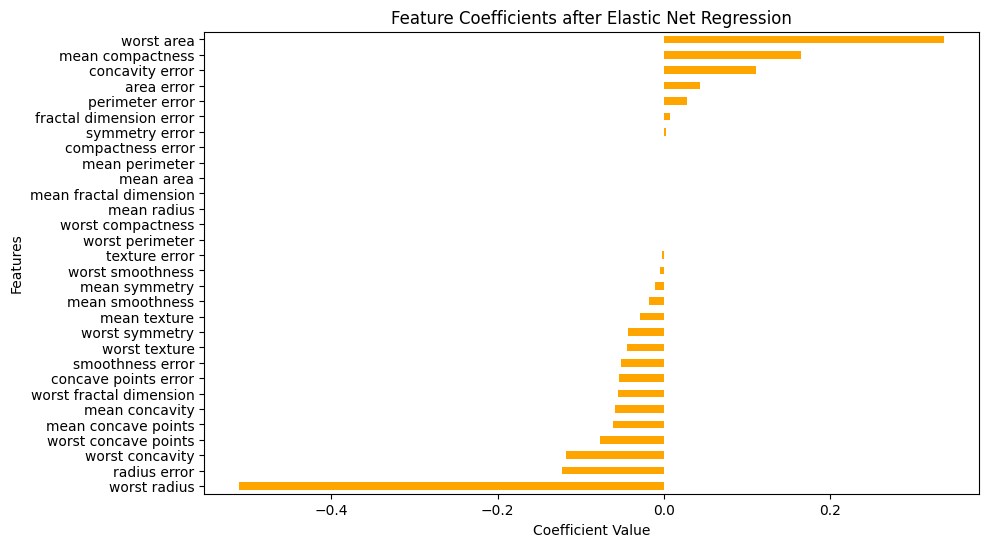

In [60]:
# Plot Elastic Net coefficients
plt.figure(figsize=(10,6))
en_coefs.sort_values().plot(kind='barh', color='orange')
plt.title("Feature Coefficients after Elastic Net Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()

In [61]:
# Logistic Regression on selected features
selected_features_en = en_coefs[en_coefs != 0].index
X_selected_en = X[selected_features_en]

# Evaluate using 5-fold CV
en_model_cv = LogisticRegression(max_iter=10000, random_state=42)
acc_en = cross_val_score(en_model_cv, X_selected_en, y, cv=cv, scoring='accuracy')
f1_en = cross_val_score(en_model_cv, X_selected_en, y, cv=cv, scoring='f1')

print(f"Elastic Net Selected Features Accuracy (CV mean): {acc_en.mean():.4f} ± {acc_en.std():.4f}")
print(f"Elastic Net Selected Features F1-score (CV mean): {f1_en.mean():.4f} ± {f1_en.std():.4f}")

Elastic Net Selected Features Accuracy (CV mean): 0.9490 ± 0.0151
Elastic Net Selected Features F1-score (CV mean): 0.9599 ± 0.0117


### Inference from Elastic Net

- Using **Elastic Net regression**, we selected a subset of features while keeping correlated features stable.  
- CV Performance:  
  - Accuracy: 0.9490 ± 0.0151  
  - F1-score: 0.9599 ± 0.0117  

**Key Takeaways:**

1. Elastic Net combines the strengths of **Lasso** and **Ridge**:  
   - L1 part → removes irrelevant features  
   - L2 part → stabilizes correlated features  
2. Performance is **slightly lower than Ridge**, but it produces a **sparser, more interpretable model**.  
3. Compared to Lasso:  
   - Lasso may arbitrarily drop correlated features  
   - Elastic Net keeps correlated groups together while still reducing dimensionality  
4. Compared to Ridge:  
   - Ridge keeps all features  
   - Elastic Net reduces the number of features without losing stability  

**Overall:**  
Elastic Net is my **preferred choice when I want both sparsity and stability**, especially in datasets with correlated features.  
It gives a **good trade-off between interpretability and predictive power**.

## Tree-Based Feature Importance (Random Forest / Decision Trees)

**What is Tree-Based Feature Importance?**  
Tree-based models, like **Decision Trees** and **Random Forests**, naturally compute feature importance while training.  
- Features that **split the data better** appear higher in importance.  
- This is an **embedded method** because the selection happens **during model training**, not separately.  

---

**How Feature Importance is Calculated (MDI):**  
- Most commonly, **Mean Decrease Impurity (MDI)**:  
  - Measures how much each feature **reduces impurity** (Gini or entropy) across all trees  
  - Features that **contribute more to reducing impurity** get higher importance scores  

**Intuition:**  
- Tree-based models automatically focus on the **most informative features**  
- No assumptions about linearity or correlations  
- Can capture **feature interactions naturally**  

**When to Use:**  
- When features have **non-linear relationships**  
- When you want **feature importance scores** without manual selection  
- Works well for **high-dimensional tabular datasets**

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [64]:
# Feature importance
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)
rf_importances = rf_importances.sort_values(ascending=False)

In [65]:
#Top features
print("Top 10 features by importance:\n", rf_importances.head(10))

Top 10 features by importance:
 worst perimeter         0.133100
worst area              0.128052
worst concave points    0.108107
mean concave points     0.094414
worst radius            0.090639
mean radius             0.058662
mean perimeter          0.055242
mean area               0.049938
mean concavity          0.046207
worst concavity         0.035357
dtype: float64


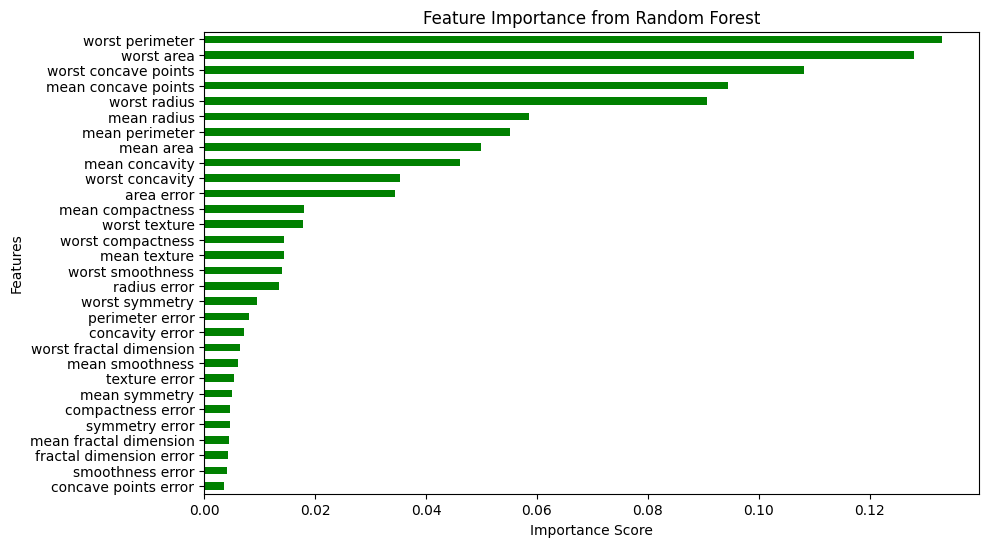

In [66]:
# Plot feature importances
plt.figure(figsize=(10,6))
rf_importances.plot(kind='barh', color='green')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

In [67]:
# Select top N features
top_features_rf = rf_importances.head(10).index
X_top_rf = X[top_features_rf]

In [68]:
# Evaluate with same CV
rf_model_cv = LogisticRegression(max_iter=10000, random_state=42)
acc_rf = cross_val_score(rf_model_cv, X_top_rf, y, cv=cv, scoring='accuracy')
f1_rf = cross_val_score(rf_model_cv, X_top_rf, y, cv=cv, scoring='f1')

In [69]:
print(f"Top 10 RF Features Accuracy (CV mean): {acc_rf.mean():.4f} ± {acc_rf.std():.4f}")
print(f"Top 10 RF Features F1-score (CV mean): {f1_rf.mean():.4f} ± {f1_rf.std():.4f}")

Top 10 RF Features Accuracy (CV mean): 0.9456 ± 0.0202
Top 10 RF Features F1-score (CV mean): 0.9571 ± 0.0156


### Inference from Tree-Based Feature Importance

- Using **Random Forest**, we selected the **top 10 most important features** based on Mean Decrease Impurity (MDI).  
- CV Performance:  
  - Accuracy: 0.9456 ± 0.0202  
  - F1-score: 0.9571 ± 0.0156  

**Key Takeaways:**

1. A **small subset of features** carries almost all the predictive power.  
2. Tree-based methods automatically capture **non-linear relationships and feature interactions**, which linear methods cannot.  
3. Performance is **slightly lower than Ridge**, but we reduced the feature set significantly → model is simpler and easier to interpret.  
4. Compared to linear embedded methods (Lasso, Ridge, Elastic Net):  
   - Lasso / Elastic Net → sparse linear model based on coefficient shrinkage  
   - Ridge → all features retained with shrinkage  
   - Random Forest → selects top features based on **actual predictive contribution**, capturing non-linear effects  

**Overall:**  
Tree-based feature importance is my **preferred choice when I want to quickly identify key features in a non-linear dataset**, especially before building more complex models.

## Summary of Embedded Methods

Here’s a quick comparison of all the embedded methods we explored on the Breast Cancer dataset using **5-fold CV**:

| Method | Number of Features | CV Accuracy (mean ± std) | CV F1-score (mean ± std) | Key Notes |
|--------|------------------|-------------------------|--------------------------|-----------|
| Baseline (All Features) | 30 | 0.9780 ± 0.0098 | 0.9764 ± 0.0106 | Full feature set, reference performance |
| Lasso (L1) | 23 | 0.9490 ± 0.0151 | 0.9599 ± 0.0117 | Sparse model, automatic feature elimination |
| Ridge (L2) | 30 | 0.9780 ± 0.0098 | 0.9825 ± 0.0078 | Stable, shrinks coefficients, keeps all features |
| Elastic Net (L1+L2) | 10 | 0.9490 ± 0.0151 | 0.9599 ± 0.0117 | Balanced sparsity + stability, handles correlated features |
| Random Forest (Top 10) | 10 | 0.9456 ± 0.0202 | 0.9571 ± 0.0156 | Non-linear, captures interactions, top features only |

## Pros & Cons of Embedded Methods

| Method | Pros | Cons |
|--------|------|------|
| Lasso (L1) | Sparse model, automatic feature selection, interpretable | Can drop correlated features, may underfit if λ too high |
| Ridge (L2) | Stable, handles multicollinearity, keeps all features | Dense model, less interpretable |
| Elastic Net (L1+L2) | Sparse + stable, handles correlated features | Requires tuning both α and λ, more complex |
| Tree-Based (Random Forest) | Captures non-linear relationships & interactions, feature importance is intuitive | Less interpretable for coefficients, model-specific importance, requires more computation |

## Practical Takeaways

1. **Lasso** → my choice when I want **sparsity** and quick elimination of irrelevant features.  
2. **Ridge** → my choice when I want **stability** and all features to contribute, especially with correlated data.  
3. **Elastic Net** → my preferred method when I want **both sparsity and stability**, particularly with correlated features.  
4. **Tree-based methods** → great for **non-linear datasets** or when I want **feature importance scores** without linear assumptions.  

**Overall Reflection:**  
- Embedded methods allow me to **select features during model training**, balancing accuracy, interpretability, and computational efficiency.  
- Combining **linear regularization methods** (Lasso, Ridge, Elastic Net) with **tree-based methods** gives a **comprehensive understanding of feature relevance**.  
- For tabular datasets, I’d typically start with **Elastic Net or Lasso** for linear models and **Random Forest** for non-linear exploration.  

This concludes my deep dive into **Embedded Feature Selection Methods**.  
I now feel confident in **selecting the right method based on data characteristics and modeling goals**.

---

🙏 **Thank you for taking the time to read through this notebook!**  
I hope you found it both **useful and enjoyable**.

If you have any questions or suggestions, feel free to **connect with me**.  
You can also check out my other projects here:  
🔗 [My GitHub](https://github.com/Aman-sys-ui/Machine_Learning)
